<a href="https://colab.research.google.com/github/SagarAdev/lithium-battery-capacity-and-risk-analysis/blob/main/notebooks/02_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note:
This notebook is designed to run on Google Colab with a GPU runtime (T4/L4).
Runtime → Change runtime type → GPU

## 1. Download Dataset
Pull the Battery Failure Surfaces dataset directly from Kaggle into the Colab environment.

In [ ]:
# Download dataset
!pip install kagglehub
import kagglehub
path = kagglehub.dataset_download("niladriroy0/battery-failure-surfaces")
print(path)

Using Colab cache for faster access to the 'battery-failure-surfaces' dataset.
/kaggle/input/battery-failure-surfaces


In [ ]:
import os
print(os.listdir(path))

['.nfs00000000840b2a5e0000005a', 'battery_failure_surfaces.csv']


## 2. Setup
Seed for reproducibility and device selection. Uses CUDA on Colab GPU, falls back to CPU locally.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")



Using device: cuda


## 3. Load & Prepare Data
Download dataset from Kaggle, drop the constant `cumulative_high_temp_cycles` column, create `cell_id` by detecting cycle resets, and one-hot encode battery chemistry.

In [ ]:
# df = pd.read_csv('../data/raw/battery_failure_surfaces.csv')
df = pd.read_csv(os.path.join(path, 'battery_failure_surfaces.csv'))
df = df.drop(columns=['cumulative_high_temp_cycles'])
df['cell_id'] = (df.groupby('cell_chemistry')['cycle'].diff()<0).cumsum()

df = pd.get_dummies(df,columns=['cell_chemistry'],dtype=float)

In [ ]:
df.head()

,cycle,charge_rate_C,discharge_rate_C,cell_temperature_C,internal_resistance_mOhm,capacity_retention_%,fast_charge_exposure_cycles,irreversible_damage_index,thermal_runaway_risk_score,cell_id,cell_chemistry_LFP,cell_chemistry_Li-ion NMC,cell_chemistry_Solid-State
0,0,1.311626,2.401429,33.544339,33.923862,99.972475,0,0.0,0.02,0,0.0,1.0,0.0
1,1,1.311626,2.401429,33.359694,33.947258,99.944950,0,0.0,0.02,0,0.0,1.0,0.0
2,2,1.311626,2.401429,33.787926,33.970654,99.917425,0,0.0,0.02,0,0.0,1.0,0.0
3,3,1.311626,2.401429,32.878808,33.994050,99.889901,0,0.0,0.02,0,0.0,1.0,0.0
4,4,1.311626,2.401429,32.150625,34.017447,99.862376,0,0.0,0.02,0,0.0,1.0,0.0


In [ ]:
FEATURE_COLS = [
    'charge_rate_C',
    'discharge_rate_C',
    'cell_temperature_C',
    'internal_resistance_mOhm',
    'fast_charge_exposure_cycles',
    'irreversible_damage_index',
    'capacity_retention_%',
    'thermal_runaway_risk_score',
    'cell_chemistry_LFP',
    'cell_chemistry_Li-ion NMC',
    'cell_chemistry_Solid-State'
]

# Columns to scale (exclude one-hot)
SCALE_COLS = [
    'charge_rate_C',
    'discharge_rate_C',
    'cell_temperature_C',
    'internal_resistance_mOhm',
    'capacity_retention_%',
    'fast_charge_exposure_cycles',
    'irreversible_damage_index',
    'thermal_runaway_risk_score',
]

TARGET =  'capacity_retention_%'

WINDOW_SIZE = 30

## 4. Temporal Split (Stratified by Chemistry)
70/15/15 split by cell Split is done within each chemistry so all three are represented in train, val, and test sets.

In [ ]:
# Temporal split by cell
train_keys = set()
val_keys = set()
test_keys = set()

for chem_col in ['cell_chemistry_LFP', 'cell_chemistry_Li-ion NMC', 'cell_chemistry_Solid-State']:
    chem_cells = df[df[chem_col] == 1]['cell_id'].unique()
    chem_cells = sorted(chem_cells)
    n = len(chem_cells)

    train_keys.update(chem_cells[:int(n * 0.7)])
    val_keys.update(chem_cells[int(n * 0.7):int(n * 0.85)])
    test_keys.update(chem_cells[int(n * 0.85):])

print(f'Train: {len(train_keys)} cells')
print(f'Val:   {len(val_keys)} cells')
print(f'Test:  {len(test_keys)} cells')


Train: 840 cells
Val:   180 cells
Test:  180 cells


## 5. Tag & Scale
Each row is tagged with its split. StandardScaler is fit on training data only, then applied to all split ensuring no information leaks from val/test into training.

In [ ]:
# Tagging the records
df['split'] = df['cell_id'].map(
    lambda cid: "train" if cid in train_keys
    else 'val' if cid in val_keys
    else 'test'
)

# Scale — fit on train only
scaler = StandardScaler()
scaler.fit(df.loc[df['split'] == 'train', SCALE_COLS])
df[SCALE_COLS] = scaler.transform(df[SCALE_COLS])

## 6. Scaled Feature Distributions
Visual check that scaling worked. Features should be roughly centered around 0. Skew is expected for damage and exposure features. Healthy cycles dominate the data.

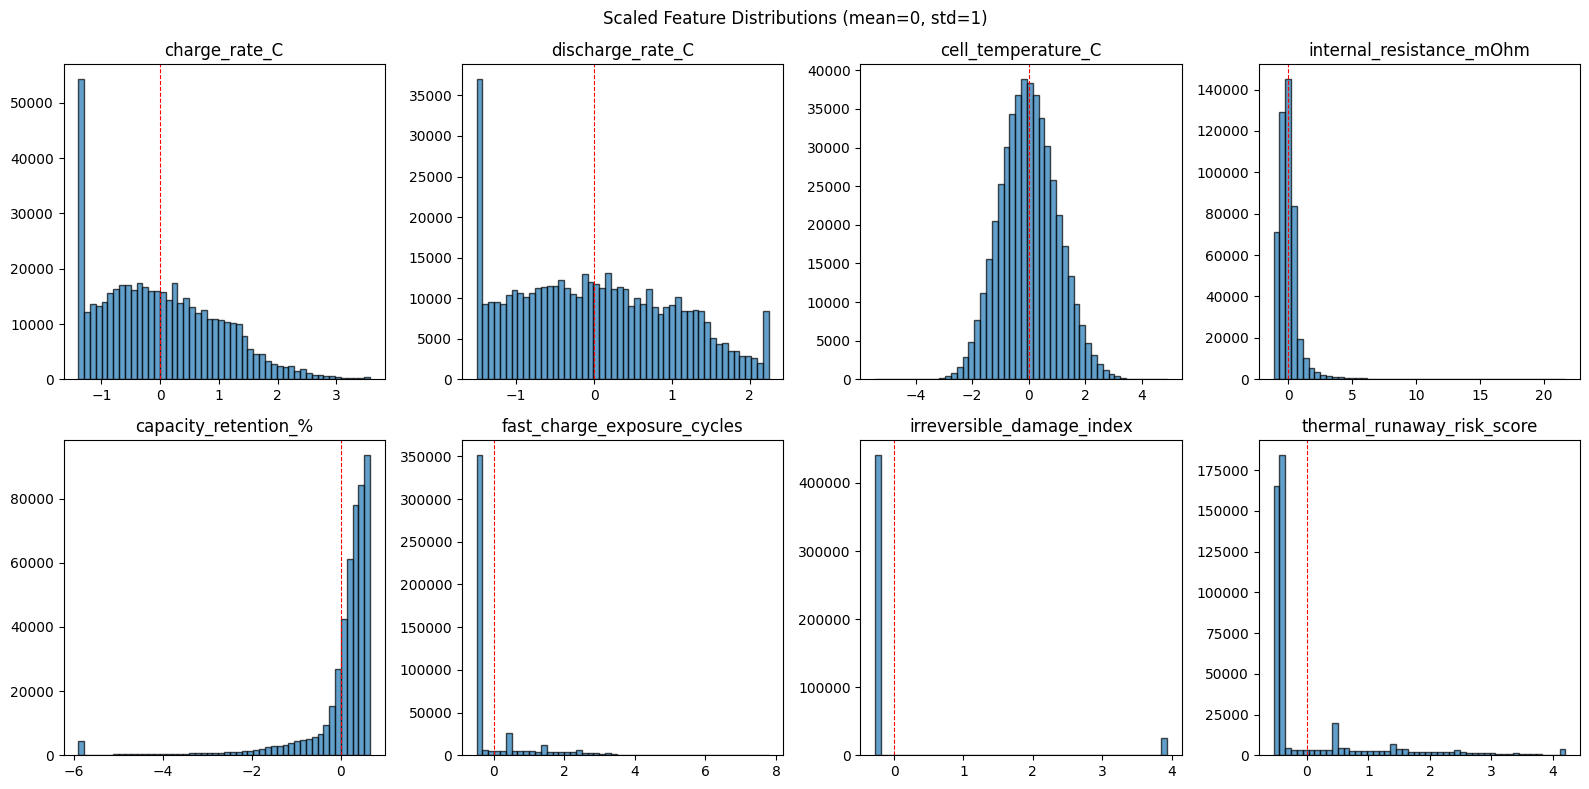

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(SCALE_COLS):
    axes[i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(col)
    axes[i].axvline(0, color='red', linestyle='--', linewidth=0.8)

plt.suptitle('Scaled Feature Distributions (mean=0, std=1)')
plt.tight_layout()
plt.show()

## 7. Sliding Window Dataset
Each cell's timeline is sliced into overlapping 30-cycle windows. Each window is paired with the next cycle's capacity as the prediction target. Windows never cross cell boundaries.

In [ ]:
class BatteryWindowDataset(Dataset):

    def __init__(self,dataframe,feature_cols,target_col,window_size=30):
        self.samples = []

        for cell_id,group in dataframe.groupby('cell_id'):
            group = group.sort_values('cycle')
            features = group[feature_cols].values.astype(np.float32)
            target = group[target_col].values.astype(np.float32)

            for i in range(len(features) - window_size):
                x = features[i:i+window_size]
                y = target[i+window_size]
                self.samples.append((x,y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        x,y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)

train_ds = BatteryWindowDataset(df[df['split']=='train'],FEATURE_COLS,TARGET,WINDOW_SIZE)
test_ds = BatteryWindowDataset(df[df['split']=='test'],FEATURE_COLS,TARGET,WINDOW_SIZE)
val_ds = BatteryWindowDataset(df[df['split']=='val'],FEATURE_COLS,TARGET,WINDOW_SIZE)

print(f'Train: {len(train_ds)} windows')
print(f'Val: {len(val_ds)} windows')
print(f'Test: {len(test_ds)} windows')

Train: 309148 windows
Val: 65436 windows
Test: 66729 windows


## 8. DataLoaders
Batch size of 256. Training data is shuffled each epoch to prevent order-dependent learning. Val and test are not shuffled.

In [ ]:
train_loader = DataLoader(train_ds,batch_size=256,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=256,shuffle=False)
test_loader = DataLoader(test_ds,batch_size=256,shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1208
Val batches: 256
Test batches: 261


## 9. LSTM Model
2-layer LSTM (hidden_size=64) with dropout, followed by a linear head that maps the final hidden state to a single capacity prediction.

In [ ]:
# Model Definition
class BatteryLSTM(nn.Module):
    def __init__(self,input_size,hidden_state=64,num_layers=2,dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_state,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_state,1)

    def forward(self,x):
        lstm_out, (h_n,c_n) = self.lstm(x)
        last_hidden = h_n[-1]
        out = self.fc(last_hidden)
        return out.squeeze(-1)


model = BatteryLSTM(input_size=len(FEATURE_COLS)).to(DEVICE)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):}")
print(model)

Parameters: 53057
BatteryLSTM(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 10. Training & Evaluation Functions
`train_one_epoch`: forward pass → loss → backprop → weight update for every batch. <br>
`evaluate`: same forward pass but no gradient computation — just measures performance.

In [ ]:
# Training Loop
def train_one_epoch(model,dataloader,optimizer,critirion):
    model.train()
    total_loss = 0
    n_batches = 0

    for X_batch,y_batch in dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        predictions = model(X_batch)
        loss = critirion(predictions,y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss/n_batches

def evaluate(model,dataloader,critirion):
    model.eval()
    total_loss = 0
    n_batches = 0

    with torch.no_grad():
        for X_batch,y_batch in dataloader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            predictions = model(X_batch)
            loss = critirion(predictions,y_batch)

            total_loss += loss.item()
            n_batches += 1

        return total_loss/n_batches



## 11. Train
Adam optimizer with ReduceLROnPlateau scheduler (halves LR after 5 stale epochs). Early stopping with patience=10 saves the best model checkpoint.

In [ ]:
def train_model(model,train_loader,val_loader,epochs=50,lr=0.003,patience=10):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,mode='min',factor=0.5,patience=5
    )
    critirion = nn.MSELoss()

    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1,epochs+1):
        train_loss = train_one_epoch(model,train_loader,optimizer,critirion)
        val_loss = evaluate(model,val_loader,critirion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(),'best_model.pt')
        else:
            patience_counter += 1

        if epoch % 5 == 0 or patience_counter == patience:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.6f}")

        if patience < patience_counter:
            print(f'\nEarly Stopping at Epoch {epoch}')
            break

    model.load_state_dict(torch.load('best_model.pt'))
    return model,history

In [ ]:
model, history = train_model(model, train_loader, val_loader)

Epoch   5 | Train: 0.000554 | Val: 0.000688 | LR: 0.003000
Epoch  10 | Train: 0.000320 | Val: 0.000091 | LR: 0.003000
Epoch  15 | Train: 0.000255 | Val: 0.000026 | LR: 0.003000
Epoch  20 | Train: 0.000202 | Val: 0.000040 | LR: 0.003000
Epoch  25 | Train: 0.000165 | Val: 0.000027 | LR: 0.003000
Epoch  30 | Train: 0.000172 | Val: 0.000051 | LR: 0.003000
Epoch  35 | Train: 0.000130 | Val: 0.000035 | LR: 0.003000
Epoch  40 | Train: 0.000331 | Val: 0.000085 | LR: 0.003000
Epoch  44 | Train: 0.000161 | Val: 0.000026 | LR: 0.003000
Epoch  45 | Train: 0.000165 | Val: 0.000031 | LR: 0.003000

Early Stopping at Epoch 45


## 12. Test Set Evaluation
Unscale predictions back to original capacity range and compute MAE/RMSE. Evaluate overall and on the worst 25% of predictions, the fast-degrading cells where accuracy matters most.

In [ ]:
def get_predictions(model,dataloader):
    model.eval()
    all_preds = []
    all_true =[]

    with torch.no_grad():
        for X_batch,y_batch in dataloader:
            preds = model(X_batch.to(DEVICE)).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(y_batch.numpy())

            return np.array(all_preds),np.array(all_true)

preds, actuals = get_predictions(model,test_loader)

cap_index = SCALE_COLS.index('capacity_retention_%')
preds_unscaled = preds * scaler.scale_[cap_index] + scaler.mean_[cap_index]
actuals_unscaled = actuals * scaler.scale_[cap_index] + scaler.mean_[cap_index]

mae = np.mean(np.abs(preds_unscaled - actuals_unscaled))
rmse = np.sqrt(np.mean((preds_unscaled - actuals_unscaled) ** 2))

print(f'Test MAE:  {mae:.4f}%')
print(f'Test RMSE: {rmse:.4f}%')

errors = np.abs(preds_unscaled - actuals_unscaled)
threshold = np.percentile(errors, 75)
tail_mae = errors[errors >= threshold].mean()

print(f'Worst 25% MAE: {tail_mae:.4f}%')

Test MAE:  0.0159%
Test RMSE: 0.0215%
Worst 25% MAE: 0.0361%


## 13. Training Curves & Predictions vs Actual
Training curves check for overfitting (val loss diverging from train loss). Scatter plot shows prediction accuracy - points close to the red diagonal line indicate good predictions.

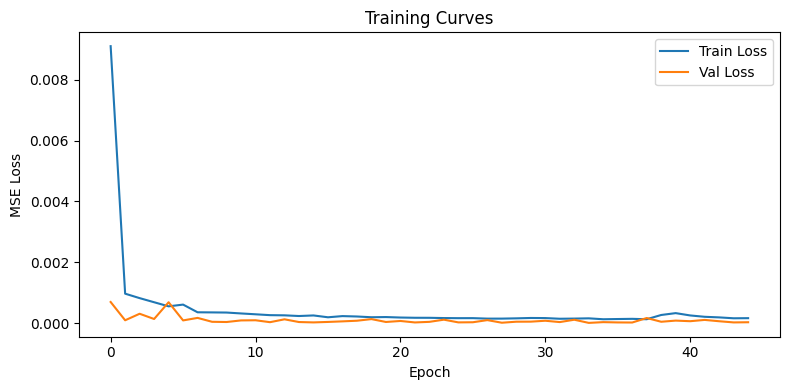

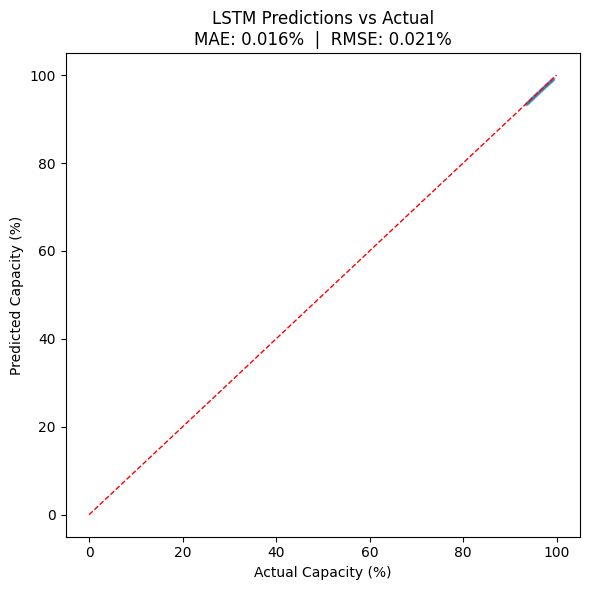

In [ ]:
# Training curves
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions vs actual
plt.figure(figsize=(6, 6))
plt.scatter(actuals_unscaled, preds_unscaled, alpha=0.05, s=3)
plt.plot([0, 100], [0, 100], 'r--', linewidth=1)
plt.xlabel('Actual Capacity (%)')
plt.ylabel('Predicted Capacity (%)')
plt.title(f'LSTM Predictions vs Actual\nMAE: {mae:.3f}%  |  RMSE: {rmse:.3f}%')
plt.tight_layout()
plt.show()

In [ ]:
preds_all = []
actuals_all = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        p = model(X_batch.to(DEVICE)).cpu().numpy()
        preds_all.extend(p)
        actuals_all.extend(y_batch.numpy())

preds_all = np.array(preds_all)
actuals_all = np.array(actuals_all)

cap_idx = SCALE_COLS.index('capacity_retention_%')
preds_unscaled = preds_all * scaler.scale_[cap_idx] + scaler.mean_[cap_idx]
actuals_unscaled = actuals_all * scaler.scale_[cap_idx] + scaler.mean_[cap_idx]
errors = np.abs(preds_unscaled - actuals_unscaled)

print(f'Errors: {len(errors)}, Labels: {len(chem_labels)}')

Errors: 66729, Labels: 66729


## 14. Per-Chemistry Performance
Evaluate the model separately on each chemistry to check if it struggles with any particular degradation pattern.

In [ ]:
# We need chemistry labels for test set
# Rebuild from the test split
test_df = df[df['split'] == 'test'].copy()

# Get chemistry per window (use the chemistry of the last cycle in each window)
chem_labels = []
for cell_id, group in test_df.groupby('cell_id'):
    group = group.sort_values('cycle')
    n_windows = len(group) - WINDOW_SIZE

    # Check which chemistry columns are 1
    if group['cell_chemistry_Li-ion NMC'].iloc[0] == 1:
        chem = 'Li-ion NMC'
    elif group['cell_chemistry_LFP'].iloc[0] == 1:
        chem = 'LFP'
    else:
        chem = 'Solid-State'

    chem_labels.extend([chem] * n_windows)

chem_labels = np.array(chem_labels)

# Per-chemistry metrics
errors = np.abs(preds_unscaled - actuals_unscaled)

for chem in ['Li-ion NMC', 'LFP', 'Solid-State']:
    mask = chem_labels == chem
    chem_mae = errors[mask].mean()
    chem_tail = errors[mask][errors[mask] >= np.percentile(errors[mask], 75)].mean()
    print(f'{chem:15s} | MAE: {chem_mae:.4f}% | Worst 25% MAE: {chem_tail:.4f}%')

Li-ion NMC      | MAE: 0.0242% | Worst 25% MAE: 0.0636%
LFP             | MAE: 0.0272% | Worst 25% MAE: 0.0691%
Solid-State     | MAE: 0.0256% | Worst 25% MAE: 0.0591%
